The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [ ]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

In [ ]:
# ----------------- CONFIG ----------------- #
DATA_FOLDER = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
OUT_DIR = Path("../data/processed/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECT_NUM = 2  # <--- Change this to pick a subject (2–17, skipping 4 and 14)
SET_TEMPLATE = "binepochs filtered ICArej P1AvgBOS{num}.set"

APPLY_BANDPASS = True
BANDPASS = (1.0, 30.0)
BASELINE = (None, 0.0)
# ------------------------------------------ #

def preprocess_epochs(epochs):
    """Applies baseline, filtering, and z-scoring per epoch."""
    if BASELINE is not None:
        epochs.apply_baseline(BASELINE)
    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    sfreq = epochs.info["sfreq"]

    # Apply 1–30 Hz bandpass filter if requested
    if APPLY_BANDPASS:
        for e in range(len(data)):
            data[e] = mne.filter.filter_data(
                data[e],
                sfreq,
                l_freq=BANDPASS[0],
                h_freq=BANDPASS[1],
                verbose=False,
            )

    # Z-score per epoch, channel-wise
    for e in range(len(data)):
        means = data[e].mean(axis=1, keepdims=True)
        stds = data[e].std(axis=1, keepdims=True)
        stds[stds == 0] = 1.0
        data[e] = (data[e] - means) / stds

    return data, sfreq


# ------------- MAIN SCRIPT ------------- #
fname = SET_TEMPLATE.format(num=SUBJECT_NUM)
set_path = DATA_FOLDER / fname

if not set_path.exists():
    raise FileNotFoundError(f"Subject {SUBJECT_NUM} file not found: {set_path}")

print(f"Processing subject {SUBJECT_NUM}...")
epochs = mne.io.read_epochs_eeglab(set_path)
ch_names = epochs.ch_names

# Split into auditory and tactile trials
auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]

aud_data, sfreq = preprocess_epochs(auditory_epochs)
tac_data, _ = preprocess_epochs(tactile_epochs)

# Transpose to (channels, epochs, timepoints)
aud_data = aud_data.transpose(1, 0, 2)
tac_data = tac_data.transpose(1, 0, 2)

print(f"Auditory shape: {aud_data.shape}")  # (32, 60, 1792)
print(f"Tactile shape:  {tac_data.shape}")

# --- Save outputs ---
aud_path = OUT_DIR / f"P1_subject{SUBJECT_NUM}_auditory.npy"
tac_path = OUT_DIR / f"P1_subject{SUBJECT_NUM}_tactile.npy"

np.save(aud_path, aud_data)
np.save(tac_path, tac_data)

print(f"Saved auditory data to {aud_path}")
print(f"Saved tactile data to  {tac_path}")

# --- Optional: Save metadata ---
meta_info = {
    "subject": SUBJECT_NUM,
    "ch_names": ch_names,
    "sfreq": sfreq,
    "BANDPASS": BANDPASS,
    "BASELINE": BASELINE,
}
np.save(OUT_DIR / f"P1_subject{SUBJECT_NUM}_meta.npy", meta_info, allow_pickle=True)
print(f"Saved metadata for subject {SUBJECT_NUM}")


Processing subject 2...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_22996\1792180321.py:54: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Applying baseline correction (mode: mean)
Auditory shape: (32, 60, 1792)
Tactile shape:  (32, 60, 1792)
Saved auditory data to ..\data\processed\P1_subject2_auditory.npy
Saved tactile data to  ..\data\processed\P1_subject2_tactile.npy
Saved metadata for subject 2


In [6]:
def select_channels(data, ch_names, picks):
    """Select channels by name or index."""
    if isinstance(picks[0], str):
        sel = [ch_names.index(ch) for ch in picks]
    else:
        sel = picks
    return data[sel, :, :], [ch_names[i] for i in sel]


In [17]:
aud = np.load("../data/processed/P1_subject2_auditory.npy")
tac = np.load("../data/processed/P1_subject2_tactile.npy")
meta = np.load("../data/processed/P1_subject2_meta.npy", allow_pickle=True).item()

print(aud.shape, tac.shape)
print("Channels:", meta["ch_names"])

x_idx = meta["ch_names"].index("C3")
y_idx = meta["ch_names"].index("T7")

x_trials = aud[x_idx]
y_trials = aud[y_idx]

print(x_trials.shape)  # (60, 1792)
print(y_trials.shape)  # (60, 1792)

(32, 60, 1792) (32, 60, 1792)
Channels: ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'POz', 'O1', 'Oz', 'O2']
(60, 1792)
(60, 1792)


In [ ]:
# ---------------- CONFIG ---------------- #
sfreq = 512           # Hz
win_s = 0.25          # seconds
win = int(win_s * sfreq)
step = win // 2       # non-overlapping windows
maxwins = 500         # cap to avoid GPU overload
base_params = {
    'n_epochs': 100,
    'learning_rate': 1e-3,
    'batch_size': 64,
    'patience': 15,
    'embedding_dim': 16,
    'hidden_dim': 64,
    'n_layers': 2
}

sweep_grid = {'critic_type': ['separable']}
lag_range = range(-250, 251, 25)
# ---------------------------------------- #

# --- Helper function: sliding window --- #
def make_windows(signal, win_len, step):
    starts = np.arange(0, len(signal) - win_len + 1, step)
    return np.stack([signal[s:s+win_len] for s in starts], axis=0)

In [32]:
# --- Initialize storage --- #
summary = []
all_curves = []
all_curves_shuf = []

# --- Iterate over trials --- #
for i in tqdm(range(x_trials.shape[0]), desc="Running trials"):
    print(f"Running trial {i+1}/{x_trials.shape[0]}...")
    x = x_trials[i]
    y = y_trials[i]

    # --- Manual windowing --- #
    Xw = make_windows(x, win, step)
    Yw = make_windows(y, win, step)

    # --- Z-score per window --- #
    Xw = (Xw - Xw.mean(axis=1, keepdims=True)) / (Xw.std(axis=1, keepdims=True) + 1e-12)
    Yw = (Yw - Yw.mean(axis=1, keepdims=True)) / (Yw.std(axis=1, keepdims=True) + 1e-12)

    # --- Skip flat or short trials --- #
    if Xw.shape[0] < 10 or np.std(Xw) < 1e-6:
        print(f"Skipping trial {i} (too few or flat windows)")
        continue

    # --- Optional subsample --- #
    Xw = Xw[:maxwins]
    Yw = Yw[:maxwins]

    # --- Shuffled control --- #
    rng = np.random.RandomState(42)
    Yw_shuf = Yw[rng.permutation(Yw.shape[0])]

    # --- Run MI estimation --- #
    res = nmi.run(
        x_data=Xw, y_data=Yw,
        mode='lag',
        processor_type_x='continuous', processor_params_x={'window_size': 1},
        processor_type_y='continuous', processor_params_y={'window_size': 1},
        base_params=base_params, sweep_grid=sweep_grid,
        lag_range=lag_range, split_mode='blocked', n_workers=1, random_seed=42
    )
    res_shuf = nmi.run(
        x_data=Xw, y_data=Yw_shuf,
        mode='lag',
        processor_type_x='continuous', processor_params_x={'window_size': 1},
        processor_type_y='continuous', processor_params_y={'window_size': 1},
        base_params=base_params, sweep_grid=sweep_grid,
        lag_range=lag_range, split_mode='blocked', n_workers=1, random_seed=42
    )

    # --- Extract MI vs lag data --- #
    lags = res.dataframe['lag'].to_numpy()
    mi_vals = res.dataframe['mi_mean'].to_numpy()
    mi_shuf = res_shuf.dataframe['mi_mean'].to_numpy()

    # --- Store curves --- #
    all_curves.append((lags, mi_vals))
    all_curves_shuf.append((lags, mi_shuf))

    # --- Compute max MI per trial --- #
    max_idx = np.argmax(mi_vals)
    summary.append({
        'trial': i + 1,
        'max_mi': mi_vals[max_idx],
        'opt_lag': lags[max_idx],
        'max_mi_shuf': np.max(mi_shuf)
    })

# --- Convert to DataFrame --- #
summary_df = pd.DataFrame(summary)
print(summary_df.head())

Running trials:   0%|          | 0/60 [00:00<?, ?it/s]

Running trial 1/60...
2025-11-04 19:47:57 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:47:57 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:47:57 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:47:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:47:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:48:09 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:48:09 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 2/60...
2025-11-04 19:48:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:48:21 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:48:21 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:48:31 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:48:31 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 3/60...
2025-11-04 19:48:41 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:48:41 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:48:41 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:48:52 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:48:52 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:48:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 4/60...
2025-11-04 19:49:03 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:03 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:03 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:13 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 5/60...
2025-11-04 19:49:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:24 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:32 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:32 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 6/60...
2025-11-04 19:49:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:42 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:42 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:49:53 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:49:53 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:49:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 7/60...
2025-11-04 19:50:03 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:03 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:03 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:13 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 8/60...
2025-11-04 19:50:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:21 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:21 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:31 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:31 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 9/60...
2025-11-04 19:50:39 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:39 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:39 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:49 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:49 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 10/60...
2025-11-04 19:50:58 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:50:58 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:50:58 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:50:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:09 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:09 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 11/60...
2025-11-04 19:51:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:20 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:20 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:30 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:30 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 12/60...
2025-11-04 19:51:39 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:39 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:39 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:48 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:48 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 13/60...
2025-11-04 19:51:58 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:51:58 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:51:58 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:51:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:07 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:07 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 14/60...
2025-11-04 19:52:17 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:17 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:17 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:27 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:27 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 15/60...
2025-11-04 19:52:37 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:37 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:37 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:47 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:47 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 16/60...
2025-11-04 19:52:57 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:52:57 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:52:57 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:52:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:06 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:06 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 17/60...
2025-11-04 19:53:16 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:16 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:16 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:25 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:25 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 18/60...
2025-11-04 19:53:35 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:35 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:35 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:45 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:45 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 19/60...
2025-11-04 19:53:54 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:53:54 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:53:54 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:53:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:03 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:03 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 20/60...
2025-11-04 19:54:14 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:14 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:14 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:24 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 21/60...
2025-11-04 19:54:34 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:34 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:34 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:43 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:43 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 22/60...
2025-11-04 19:54:52 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:54:52 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:54:52 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:54:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:01 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:01 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 23/60...
2025-11-04 19:55:10 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:10 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:10 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:19 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:19 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 24/60...
2025-11-04 19:55:28 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:28 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:28 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:37 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:37 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 25/60...
2025-11-04 19:55:46 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:46 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:46 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:55:55 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:55:55 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:55:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 26/60...
2025-11-04 19:56:05 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:05 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:05 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:13 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 27/60...
2025-11-04 19:56:22 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:22 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:22 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:31 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:31 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 28/60...
2025-11-04 19:56:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:42 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:42 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:56:51 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:56:51 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:56:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 29/60...
2025-11-04 19:57:00 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:00 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:00 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:10 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:10 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 30/60...
2025-11-04 19:57:18 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:18 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:18 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:27 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:27 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 31/60...
2025-11-04 19:57:37 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:37 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:37 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:48 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:48 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 32/60...
2025-11-04 19:57:58 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:57:58 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:57:58 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:57:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:58:08 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:58:08 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 33/60...
2025-11-04 19:58:19 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:58:19 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:58:19 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:58:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:58:30 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:58:30 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 34/60...
2025-11-04 19:58:41 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:58:41 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:58:41 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:58:51 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:58:51 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:58:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 35/60...
2025-11-04 19:59:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:01 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:01 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:12 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:12 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 36/60...
2025-11-04 19:59:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:21 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:21 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:32 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:32 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 37/60...
2025-11-04 19:59:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:42 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:42 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 19:59:53 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 19:59:53 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 19:59:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 38/60...
2025-11-04 20:00:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:02 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:02 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:12 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:12 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 39/60...
2025-11-04 20:00:22 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:22 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:22 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:32 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:32 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 40/60...
2025-11-04 20:00:43 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:43 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:43 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:00:53 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:00:53 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:00:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 41/60...
2025-11-04 20:01:04 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:04 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:04 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:15 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:15 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 42/60...
2025-11-04 20:01:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:24 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:33 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:33 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 43/60...
2025-11-04 20:01:43 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:43 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:43 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:01:54 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:01:54 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:01:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 44/60...
2025-11-04 20:02:04 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:04 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:04 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:15 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:15 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 45/60...
2025-11-04 20:02:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:24 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:33 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:33 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 46/60...
2025-11-04 20:02:43 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:43 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:43 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:02:54 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:02:54 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:02:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 47/60...
2025-11-04 20:03:05 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:05 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:05 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:14 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:15 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:15 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 48/60...
2025-11-04 20:03:26 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:26 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:26 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:36 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:36 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 49/60...
2025-11-04 20:03:45 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:45 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:45 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:03:57 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:03:57 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:03:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 50/60...
2025-11-04 20:04:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:07 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:07 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:15 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:17 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:17 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:25 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:26 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 51/60...
2025-11-04 20:04:27 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:27 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:27 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:36 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:38 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:38 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 52/60...
2025-11-04 20:04:48 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:48 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:48 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:04:58 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:04:58 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:58 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:04:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 53/60...
2025-11-04 20:05:09 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:05:09 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:05:09 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:09 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:05:20 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:05:20 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 54/60...
2025-11-04 20:05:30 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:05:30 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:05:30 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:05:41 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:05:41 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:41 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 55/60...
2025-11-04 20:05:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:05:51 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:05:51 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:05:52 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:01 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:01 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:02 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:03 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:10 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:11 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 56/60...
2025-11-04 20:06:12 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:12 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:12 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:12 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:13 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:21 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:22 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:23 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:23 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:23 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:24 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:31 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:32 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 57/60...
2025-11-04 20:06:33 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:33 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:33 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:33 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:34 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:35 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:42 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:43 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:44 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:44 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:44 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:45 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:46 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:53 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:54 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 58/60...
2025-11-04 20:06:55 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:06:55 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:06:55 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:55 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:56 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:06:57 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:04 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:05 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:07:06 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:07:06 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:06 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:07 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:08 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:16 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:17 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:18 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 59/60...
2025-11-04 20:07:19 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:07:19 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:07:19 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:19 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:20 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:27 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:28 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:07:29 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:07:29 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:29 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:30 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:37 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:38 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Running trial 60/60...
2025-11-04 20:07:39 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:07:39 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:07:39 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:39 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:40 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:47 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:48 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:49 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 20:07:50 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-11-04 20:07:50 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/21 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:50 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag-125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag-100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:51 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag-75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag-25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag25_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (48). Reducing to 48.


Run lag75_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:07:59 - neural_mi - WARNING - batch_size (64) > n_train_samples (26). Reducing to 26.


Run lag100_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag125_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag150_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag175_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag200_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:00 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag225_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-04 20:08:01 - neural_mi - WARNING - batch_size (64) > n_train_samples (25). Reducing to 25.


Run lag250_combo0:   0%|          | 0/100 [00:00<?, ?it/s]

   trial    max_mi  opt_lag  max_mi_shuf
0      1  3.109306        0     3.015135
1      2  3.118126        0     2.886738
2      3  2.782533      -25     2.941500
3      4  2.759172        0     2.970075
4      5  2.593551      -25     2.827134


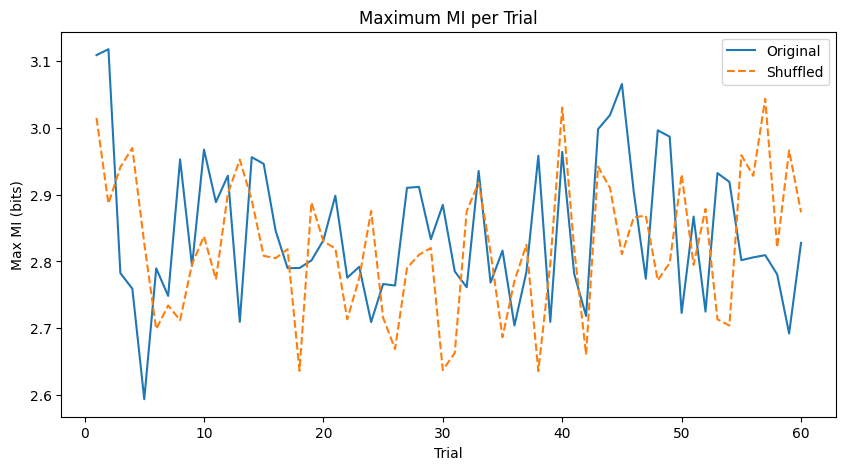

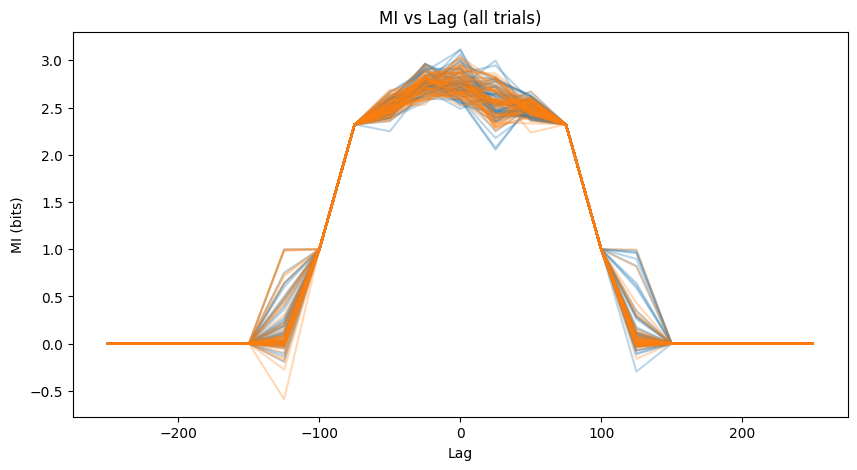

In [33]:
# --- Plot 1: max MI per trial --- #
plt.figure(figsize=(10, 5))
plt.plot(summary_df['trial'], summary_df['max_mi'], label='Original')
plt.plot(summary_df['trial'], summary_df['max_mi_shuf'], label='Shuffled', linestyle='--')
plt.xlabel("Trial")
plt.ylabel("Max MI (bits)")
plt.title("Maximum MI per Trial")
plt.legend()
plt.show()

# --- Plot 2: overlay all MI vs lag curves --- #
plt.figure(figsize=(10, 5))
for lags, mi_vals in all_curves:
    plt.plot(lags, mi_vals, color='C0', alpha=0.3)
for lags, mi_shuf in all_curves_shuf:
    plt.plot(lags, mi_shuf, color='C1', alpha=0.3)
plt.xlabel("Lag")
plt.ylabel("MI (bits)")
plt.title("MI vs Lag (all trials)")
plt.show()